# Model Performance Analysis

* This worksheet is created to create a single source of truth of performanced for all the trained models.
* At different points in time we trained different models and saved its performance metrics in different format and files.  So the idea here is to unify the number to get a better big picture. 
* The main tasks of the worksheet is these
    * Load the different models that we've saved
    * Load the appropriate test data for the models (ensemble might have different test set than regular ML models)
    * Predict against the test data and calculate performance numbers
    * Save the numbers in csv file and create visualizations for comparison

## Import Libraries

In [12]:
from sklearn.preprocessing import Binarizer, OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from pathlib import Path
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import joblib
import json
import gdown
import os
import sys
import tqdm
import time
import warnings
from huggingface_hub import login, HfApi,list_repo_files, hf_hub_download
import os
import sys
import dotenv
from pathlib import Path
import tqdm
from sklearn.model_selection import train_test_split


## Setup Hugging Face

In [6]:
dotenv.load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

## login huggingface user
if HF_TOKEN is None:
    print("Please set the HF_TOKEN environment variable. This is you hugging face token")
else:
    print("Logging in...")
    login(HF_TOKEN)
    
api = HfApi()
user = api.whoami()
user_name = user['name']
print(f"Logged in as {user_name}")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Logging in...
Logged in as gaurangdave


## Download Models & Data

In [7]:
# # Get the directory of the notebook
## this is root directory of jupyterlab
notebook_dir = os.getcwd()

# from api.utils.common import augment_dataset,download_data_from_gdrive
project_root = os.path.abspath(os.path.join(notebook_dir , "mnist_digits_recognition"))  
model_root = os.path.join(project_root, "models")
ensemble_root = project_root + '/models/ensemble/'
data_root = os.path.join(project_root, "data")

## hugging face repo id
model_name = "mnist_digits_recognition"
repo_id = f"{user_name}/{model_name}"


In [8]:
all_models = api.list_repo_files(repo_id, repo_type="model")

print(f"Models in {repo_id}:")
for model in all_models:
    ## download to tmp folder
    file_path = hf_hub_download(repo_id=repo_id, filename=model, token=HF_TOKEN, local_dir=model_root, repo_type="model")
    ## move to model folder
    os.rename(file_path, os.path.join(model_root, model))
    print(f"Downloaded {model} to {file_path}")

print(f"✅ All files downloaded to {model_root}")

Models in gaurangdave/mnist_digits_recognition:
Downloaded .gitattributes to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/.gitattributes
Downloaded default_logistic_regression_probabilites.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/default_logistic_regression_probabilites.csv
Downloaded ensemble/blended_gb.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/blended_gb.pkl
Downloaded ensemble/blended_logistic_regression_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/blended_logistic_regression_model.pkl
Downloaded ensemble/blended_random_forest_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/blended_random_forest_model.pkl
Downloaded ensemble/blended_svc_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recognition/models/ensemble/blended_svc_model.pkl
Downloaded ensemble/extra_trees_model.pkl to /home/gaurangdave/jupyterlab/mnist_digits_recogniti

In [9]:
all_data = api.list_repo_files(repo_id, repo_type="dataset")
    
print(f"Datasets in {repo_id}:")
for dataset in all_data:
    ## download to tmp folder
    file_path = hf_hub_download(repo_id=repo_id, filename=dataset, token=HF_TOKEN, local_dir=data_root, repo_type="dataset")
    ## move to model folder
    os.rename(file_path, os.path.join(data_root, dataset))
    print(f"Downloaded {dataset} to {file_path}")

print(f"✅ All files downloaded to {model_root}")

    

Datasets in gaurangdave/mnist_digits_recognition:
Downloaded .gitattributes to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/.gitattributes
Downloaded augmented_ensemle_learning_mnist_data.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/augmented_ensemle_learning_mnist_data.csv
Downloaded augmented_mnist_data.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/augmented_mnist_data.csv
Downloaded augmented_train_X.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/augmented_train_X.csv
Downloaded augmented_train_Y.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/augmented_train_Y.csv
Downloaded ensemble_performance_scores.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/ensemble_performance_scores.csv
Downloaded meta_X.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/meta_X.csv
Downloaded meta_X_test.csv to /home/gaurangdave/jupyterlab/mnist_digits_recognition/data/meta_X_test.

## Load Models

In [10]:
## load the latest version of non ensemble models
svc_augmented = joblib.load(model_root + '/svc_augmented_data_v1.joblib')

## create dictionary of models for easy access
models = {
    "svc_augmented": svc_augmented,
}


## load the latest version of ensemble models

logistic_regression = joblib.load(ensemble_root + 'logistic_regression_model.pkl')
tuned_logistic_regression = joblib.load(ensemble_root + 'tuned_logistic_regression_model.pkl')
ensemble_svc = joblib.load(ensemble_root + 'svc_model.pkl')
tuned_svc = joblib.load(ensemble_root + 'tuned_svc_model.pkl')
random_forest = joblib.load(ensemble_root + 'random_forest_model.pkl')
tuned_random_forest = joblib.load(ensemble_root + 'tuned_random_forest_model.pkl')
ensemble_knn = joblib.load(ensemble_root + 'knn_model.pkl')
tuned_knn = joblib.load(ensemble_root + 'tuned_knn_model.pkl')
extra_trees = joblib.load(ensemble_root + 'extra_trees_model.pkl')
tuned_extra_trees = joblib.load(ensemble_root + 'tuned_extra_trees_model.pkl')
gradient_boosting = joblib.load(ensemble_root + 'gradient_boosting_model.pkl')
tuned_gradient_boosting = joblib.load(ensemble_root + 'tuned_gradient_boosting_model.pkl')
voting_classifier = joblib.load(ensemble_root + 'voting_classifier_model.pkl')
tuned_voting_classifier = joblib.load(ensemble_root + 'tuned_voting_classifier_model.pkl')
soft_voting_classifier = joblib.load(ensemble_root + 'soft_voting_classifier_model.pkl')
tuned_soft_voting_classifier = joblib.load(ensemble_root + 'tuned_soft_voting_classifier_model.pkl')

## these are the estimators that will create input for the blender
estimators = {
    "logistic_regression": logistic_regression,
    "tuned_logistic_regression": tuned_logistic_regression,
    "svc": ensemble_svc,
    "tuned_svc": tuned_svc,
    "random_forest": random_forest,
    "tuned_random_forest": tuned_random_forest,
    "knn": ensemble_knn,
    "tuned_knn": tuned_knn,
    "extra_trees": extra_trees,
    "tuned_extra_trees": tuned_extra_trees,
    "gradient_boosting": gradient_boosting,
    "tuned_gradient_boosting": tuned_gradient_boosting,
    "voting_classifier": voting_classifier,
    "tuned_voting_classifier": tuned_voting_classifier,
    "soft_voting_classifier": soft_voting_classifier,
    "tuned_soft_voting_classifier": tuned_soft_voting_classifier
}


## load all the blenders
blended_gb = joblib.load(ensemble_root + 'blended_gb.pkl')
blended_logistic_regression = joblib.load(ensemble_root + 'blended_logistic_regression_model.pkl')
blended_random_forest = joblib.load(ensemble_root + 'blended_random_forest_model.pkl')
blended_svc = joblib.load(ensemble_root + 'blended_svc_model.pkl')

## create dictionary of blenders for easy access
blenders = {
    "blended_gb": blended_gb,
    "blended_logistic_regression": blended_logistic_regression,
    "blended_random_forest": blended_random_forest,
    "blended_svc": blended_svc
}


## Load Data

In [11]:
## Lets load the test set for augmented model
test_data_for_augmented = pd.read_csv(data_root + '/mnist_test_set.csv')
augmented_test_X = test_data_for_augmented.drop("class", axis=1)
augmented_test_Y = test_data_for_augmented["class"]

In [13]:
## lets load data for ensemble models
raw_data = pd.read_csv(data_root + '/raw_mnist_data.csv')

## split the data into variables and target
X = raw_data.drop(columns=['class'])
y = raw_data['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test.shape, y_test.shape

((14000, 784), (14000,))

In [14]:
## lets load test data for blender
meta_X_test = pd.read_csv(data_root + '/meta_X_test.csv')
meta_y_test = pd.read_csv(data_root + '/meta_y_test.csv')

## Create Placeholder Dataset

**RUN THE BELOW CELL ONLY ONCE**

In [ ]:

## create a placeholder dataframe for performance metrics
# final_performance_metrics = pd.DataFrame(columns=['model', 'f1_score', 'accuracy', 'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9'])

# ## save the performance metrics
# final_performance_metrics.to_csv(data_root + '/final_performance_metrics.csv', index=False)

# ## save the performance metrics to huggingface
# ## upload the model to hugging face
# path_or_fileobj = Path(data_root , 'final_performance_metrics.csv')
# path_in_repo = path_or_fileobj.relative_to(data_root)
# api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")



CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/8a5903a76ba26d66041e2ff86086507b209eb2ca', commit_message='Upload final_performance_metrics.csv with huggingface_hub', commit_description='', oid='8a5903a76ba26d66041e2ff86086507b209eb2ca', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

In [31]:
## lets read the performance metrics
final_performance_metrics = pd.read_csv(data_root + '/final_performance_metrics.csv')
final_performance_metrics

,model,f1_score,accuracy,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9


## Performance Calculations

In [32]:
## helper function to get the performance metrics

def get_performance_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    per_class_f1_scores = f1_score(y_test, y_pred, average=None)
    per_class_f1_dict = {f"class_{i}": score
                     for i, score in enumerate(per_class_f1_scores)}
    return f1, accuracy, per_class_f1_dict
    

### SVC

In [33]:
f1, accuracy, class_wise_f1 = get_performance_metrics(svc_augmented, augmented_test_X, augmented_test_Y)

In [34]:
## add the performance metrics to the final_performance_metrics dataframe
final_performance_metrics.dropna(inplace=True)
final_performance_metrics = pd.concat([final_performance_metrics, pd.DataFrame([{'model': 'SVC Augmented Data', 'f1_score': f1, 'accuracy': accuracy, **class_wise_f1}])], ignore_index=True)


/tmp/ipykernel_1473/3293290367.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_performance_metrics = pd.concat([final_performance_metrics, pd.DataFrame([{'model': 'SVC Augmented Data', 'f1_score': f1, 'accuracy': accuracy, **class_wise_f1}])], ignore_index=True)


### Voting Classifier

In [35]:
voting_classifier_dict = {
    "Hard Voting Classifier": voting_classifier,
    "Tuned Hard Voting Classifier": tuned_voting_classifier,
    "Soft Voting Classifier": soft_voting_classifier,
    "Tuned Soft Voting Classifier": tuned_soft_voting_classifier
}

for model_name, model in voting_classifier_dict.items():
    f1, accuracy, class_wise_f1 = get_performance_metrics(model, X_test, y_test)
    final_performance_metrics = pd.concat([final_performance_metrics, pd.DataFrame([{'model': model_name, 'f1_score': f1, 'accuracy': accuracy, **class_wise_f1}])], ignore_index=True)

In [36]:
final_performance_metrics

,model,f1_score,accuracy,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,SVC Augmented Data,0.989713,0.989714,0.995309,0.993016,0.988185,0.989821,0.988270,0.987694,0.990932,0.988010,0.991196,0.984218
1,Hard Voting Classifier,0.970827,0.970857,0.987379,0.981683,0.965120,0.958885,0.970464,0.970751,0.982444,0.970159,0.961940,0.958719
2,Tuned Hard Voting Classifier,0.973629,0.973643,0.988086,0.983811,0.967325,0.961565,0.973077,0.974016,0.984263,0.971770,0.966927,0.964856
3,Soft Voting Classifier,0.972620,0.972643,0.989944,0.982326,0.968046,0.962574,0.970282,0.971698,0.982494,0.972185,0.965440,0.960452
4,Tuned Soft Voting Classifier,0.977495,0.977500,0.989560,0.985363,0.973618,0.969570,0.975290,0.979528,0.986753,0.976482,0.971471,0.966901


### Blenders

In [37]:
blenders = {
    "Blended Gradient Boosting": blended_gb,
    "Blended Logistic Regression": blended_logistic_regression,
    "Blended Random Forest": blended_random_forest,
    "Blended SVC": blended_svc
}

for model_name, model in blenders.items():
    f1, accuracy, class_wise_f1 = get_performance_metrics(model, meta_X_test, meta_y_test)
    final_performance_metrics = pd.concat([final_performance_metrics, pd.DataFrame([{'model': model_name, 'f1_score': f1, 'accuracy': accuracy, **class_wise_f1}])], ignore_index=True)

In [38]:
final_performance_metrics

,model,f1_score,accuracy,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,SVC Augmented Data,0.989713,0.989714,0.995309,0.993016,0.988185,0.989821,0.988270,0.987694,0.990932,0.988010,0.991196,0.984218
1,Hard Voting Classifier,0.970827,0.970857,0.987379,0.981683,0.965120,0.958885,0.970464,0.970751,0.982444,0.970159,0.961940,0.958719
2,Tuned Hard Voting Classifier,0.973629,0.973643,0.988086,0.983811,0.967325,0.961565,0.973077,0.974016,0.984263,0.971770,0.966927,0.964856
3,Soft Voting Classifier,0.972620,0.972643,0.989944,0.982326,0.968046,0.962574,0.970282,0.971698,0.982494,0.972185,0.965440,0.960452
4,Tuned Soft Voting Classifier,0.977495,0.977500,0.989560,0.985363,0.973618,0.969570,0.975290,0.979528,0.986753,0.976482,0.971471,0.966901
5,Blended Gradient Boosting,0.987853,0.987857,0.994413,0.994382,0.985915,0.985325,0.985340,0.986215,0.992148,0.986383,0.985561,0.982011
6,Blended Logistic Regression,0.974075,0.974071,0.990320,0.988722,0.970535,0.967403,0.954072,0.966537,0.976367,0.972776,0.970961,0.979476
7,Blended Random Forest,0.985927,0.985929,0.994034,0.993134,0.982304,0.983894,0.983404,0.986215,0.990714,0.982143,0.982988,0.979866
8,Blended SVC,0.976375,0.976357,0.992537,0.989052,0.972504,0.969825,0.963837,0.977444,0.987152,0.971485,0.961326,0.976612


In [39]:
## save the performance metrics
final_performance_metrics.to_csv(data_root + '/final_performance_metrics.csv', index=False)

## save the performance metrics to huggingface
## upload the model to hugging face
path_or_fileobj = Path(data_root , 'final_performance_metrics.csv')
path_in_repo = path_or_fileobj.relative_to(data_root)

api.upload_file(repo_id=repo_id, path_or_fileobj=path_or_fileobj,path_in_repo=str(path_in_repo), token=HF_TOKEN, repo_type="dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition/commit/a73f039cd9e5788af0d45abb15dd989e16ce13c2', commit_message='Upload final_performance_metrics.csv with huggingface_hub', commit_description='', oid='a73f039cd9e5788af0d45abb15dd989e16ce13c2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/gaurangdave/mnist_digits_recognition', endpoint='https://huggingface.co', repo_type='dataset', repo_id='gaurangdave/mnist_digits_recognition'), pr_revision=None, pr_num=None)

## Performance Analysis

In [ ]:
## lets create visualizations for the performance metrics
final_performance_metrics = pd.read_csv(data_root + '/final_performance_metrics.csv')



final_performance_metrics = final_performance_metrics.round(4)

In [45]:
final_performance_metrics

,model,f1_score,accuracy,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,SVC Augmented Data,0.9897,0.9897,0.9953,0.9930,0.9882,0.9898,0.9883,0.9877,0.9909,0.9880,0.9912,0.9842
1,Hard Voting Classifier,0.9708,0.9709,0.9874,0.9817,0.9651,0.9589,0.9705,0.9708,0.9824,0.9702,0.9619,0.9587
2,Tuned Hard Voting Classifier,0.9736,0.9736,0.9881,0.9838,0.9673,0.9616,0.9731,0.9740,0.9843,0.9718,0.9669,0.9649
3,Soft Voting Classifier,0.9726,0.9726,0.9899,0.9823,0.9680,0.9626,0.9703,0.9717,0.9825,0.9722,0.9654,0.9605
4,Tuned Soft Voting Classifier,0.9775,0.9775,0.9896,0.9854,0.9736,0.9696,0.9753,0.9795,0.9868,0.9765,0.9715,0.9669
5,Blended Gradient Boosting,0.9879,0.9879,0.9944,0.9944,0.9859,0.9853,0.9853,0.9862,0.9921,0.9864,0.9856,0.9820
6,Blended Logistic Regression,0.9741,0.9741,0.9903,0.9887,0.9705,0.9674,0.9541,0.9665,0.9764,0.9728,0.9710,0.9795
7,Blended Random Forest,0.9859,0.9859,0.9940,0.9931,0.9823,0.9839,0.9834,0.9862,0.9907,0.9821,0.9830,0.9799
8,Blended SVC,0.9764,0.9764,0.9925,0.9891,0.9725,0.9698,0.9638,0.9774,0.9872,0.9715,0.9613,0.9766


### Comparing F1 Score & Accuracy Across Models

In [56]:
# First, melt the dataframe to long format for Plotly
melted_df = final_performance_metrics.melt(
    id_vars="model",
    value_vars=["accuracy", "f1_score"],
    var_name="Metric",
    value_name="Score"
)

# Create the grouped bar chart
fig = px.bar(
    melted_df,
    x="model",
    y="Score",
    color="Metric",
    barmode="group",
    text="Score",
    title="Comparison of Model Performance Metrics",
    color_discrete_map={"accuracy": "#4C72B0", "f1_score": "#55A868"}
)

# Improve layout
fig.update_layout(
    xaxis_tickangle=-35,
    yaxis=dict(range=[0.95, 1]),
    legend_title_text="Metric",
    height=600,
    width=1000
)

# Format text on bars
# fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')

fig.show()

Observations:
* We have a clear winner here `SVC` trained with `Augmented Data` with `F1 Score` and `Accuracy` of almost `0.99`
* It also interesting to see `Blended Gradient Boosting` and `Blended Random Forest` close second and third. With `Random Forest` if we are ok loosing the little bit of accuracy `~0.004` we might end up with a model that can be retrained with new data faster and get almost similar predictions. We can also experiment with removing `SVC` from the blender and seeing the results. I think the performance shouldn't degrade too much since we had bunch of highly correlated redundant features. 
* But for now its safe to say we can use `SVC Augmented Data` model in production and we'll get amazing results.

### Comparing Class Based F1 Scores Across Models

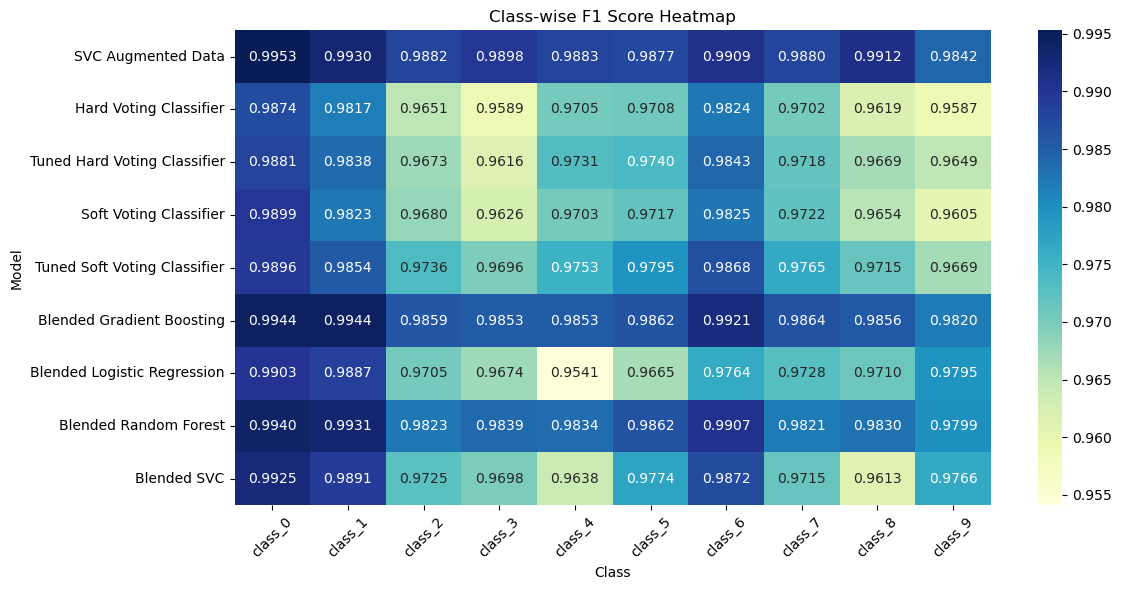

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract per-class F1 scores
class_cols = [col for col in final_performance_metrics.columns if col.startswith("class_")]
heatmap_data = final_performance_metrics.set_index('model')[class_cols]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Class-wise F1 Score Heatmap")
plt.xlabel("Class")
plt.ylabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observations:
* These aligns with overall `F1 Score` and `Accuracy` of the models. 
* One interesting observations is almost all models are relatively struggling with digits `2,3,8 and 9`. My guess is models are getting confusing 2 for 9, 3 for 8 and vice versa, since these hand written digits can be similar.
* We can confirm these findings in confusion matrix and focus on some targetted training for future enhancements. 

### Comparing Difference in Class Based F1 Scores Across Models

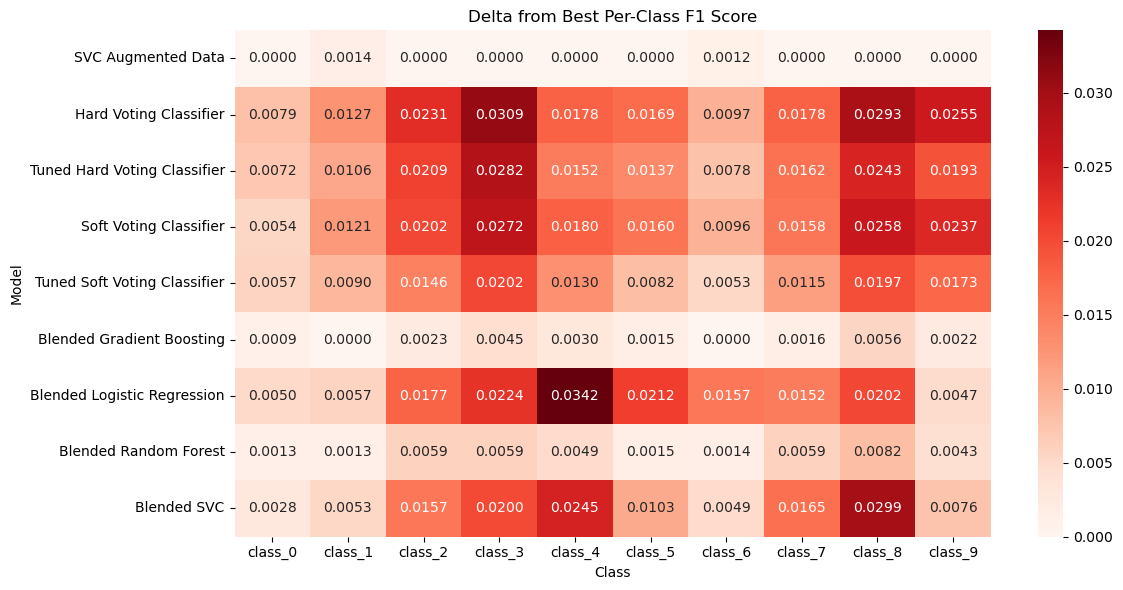

In [55]:
best_scores = final_performance_metrics[class_cols].max()
delta_df = final_performance_metrics.copy()
for col in class_cols:
    delta_df[col] = best_scores[col] - delta_df[col]

plt.figure(figsize=(12, 6))
sns.heatmap(delta_df.set_index("model")[class_cols], annot=True, fmt=".4f", cmap="Reds")
plt.title("Delta from Best Per-Class F1 Score")
plt.xlabel("Class")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

### Class wise F1 Score Districution

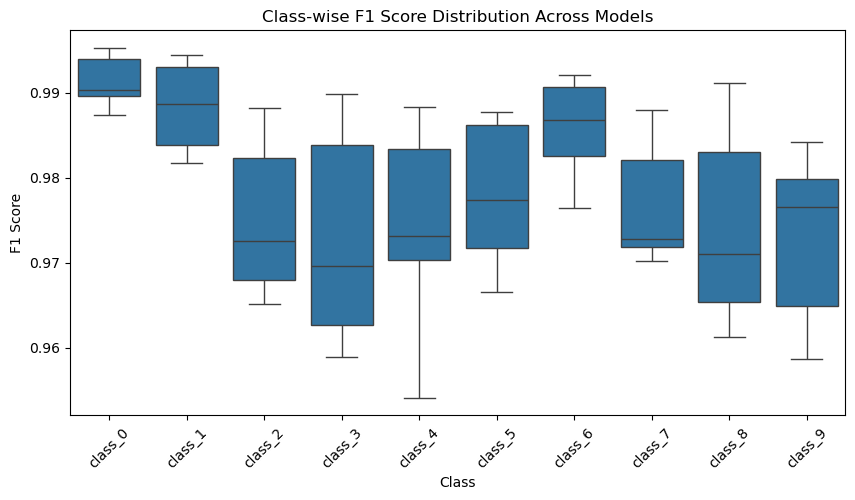

In [58]:
## Helps you understand which class is consistently hard across models.
melted_classes = final_performance_metrics.melt(
    id_vars=["model"],
    value_vars=class_cols,
    var_name="Class",
    value_name="F1 Score"
)

plt.figure(figsize=(10, 5))
sns.boxplot(data=melted_classes, x="Class", y="F1 Score")
plt.title("Class-wise F1 Score Distribution Across Models")
plt.xticks(rotation=45)
plt.show()

Observations:
* This distribution further confirms our undertanding of classification errors.
* `2,3,8 and 9` have the widest distribution telling us model's with the center lower than other digits indicating more scope of improvements over here. 